In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.beta import Beta
import numpy as np
import pandas as pd
import random
import pickle
import base64
import matplotlib.pyplot as plt
import re
from sklearn.metrics import f1_score

In [ ]:
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
SEED = 44
torch.manual_seed(SEED)
MODEL_SIZE = 2 # Integer between 1 and 4, with larger values representing progressively larger values
EMB_SIZE = 'base' # 'base' 768 embeddings or 'large' 1024 embeddings
EMBEDDINGS = 'hubert_embeddings'
SAVE_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/average/model.pth')
SAVE_WEIGHTS_WITHOUT_HEAD_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/average/model_without_head.pth')
SAVE_PLOT_IMG_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/average/loss.png')

In [ ]:
train_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/train_dataset.csv')
validation_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/validation_dataset.csv')
aug_train_csv_file = os.path.join(DATASET_FILEPATH, '/base/aug-dataset/processed/train_dataset.csv')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cpu


In [ ]:
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name', 'classification', EMBEDDINGS, 'bert_embeddings']

train_df = pd.read_csv(train_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})
validation_df = pd.read_csv(validation_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})

In [ ]:
def process_training_set(train_df, oversample_minority=False, undersample_majority=False):
  """
  Re-sample the training dataset, with options to oversample minority class and undersample majority class based on audio lengths.

  :param train_df: DataFrame containing the training data with columns ['classification', 'audio_file_name'] among others.
  :param oversample_minority: Boolean, if True, the minority class (classification == 0) is duplicated to balance the dataset.
  :param undersample_majority: Boolean, if True, majority class data with audio lengths above a threshold (specified by DROP_SEGMENTS) are dropped.
  :returns: DataFrame with the desired processed training data.
  """
  if oversample_minority:
    class_0 = train_df[train_df['classification'] == 0]
    train_df = pd.concat([train_df, class_0])
  if undersample_majority:
    DROP_SEGMENTS = 5
    def get_audio_length_group(file_name):
        return int(re.findall(r'\d+', file_name)[-1])
    train_df['audio_length_group'] = train_df['audio_file_name'].apply(get_audio_length_group)
    train_df = train_df[train_df['audio_length_group'] <= DROP_SEGMENTS]
    train_df = train_df.drop(columns=['audio_length_group'])

  # some indices are duplicated / removed so we have to reset them
  train_df.reset_index(drop=True, inplace=True)
  return train_df

def print_dataset_balance(df):
    """
    Prints the balance of classifications in a given dataset.

    :param df: DataFrame containing the data with a 'classification' column.
    """
    classification_counts = df['classification'].value_counts().reset_index()
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

def augment_train_dataset(df, augmented_df_filepath):
  """
  Introduce additional 'non-interruption' samples to the dataset, which have been extracted from the GAP dataset with an LLM.

  :param df: Original DataFrame containing the training data.
  :param augmented_df_filepath: Filepath to the CSV containing the augmented data.
  :returns: A combined DataFrame of the original and augmented training data.
  """
  selected_columns = ['audio_file_name','classification', 'wav2vec_embeddings', 'hubert_embeddings']
  aug_train_df = pd.read_csv(aug_train_csv_file, usecols=selected_columns, converters={'wav2vec_embeddings': to_tensor, 'hubert_embeddings' : to_tensor})
  augmented_df = pd.concat([df, aug_train_df], ignore_index=True)
  return augmented_df

In [ ]:
AUGMENT = False
if AUGMENT:
  print("Length of the DataFrame before:", len(train_df))
  train_df = augment_train_dataset(train_df, aug_train_csv_file)
  print("Length of the DataFrame after:", len(train_df))
else:
  train_df = process_training_set(train_df, oversample_minority=True, undersample_majority=True, prune=False)

print_dataset_balance(train_df)

# Apply means across hubert embeddings
train_df[EMBEDDINGS] = train_df[EMBEDDINGS].apply(lambda x: torch.mean(x, dim=0))
validation_df[EMBEDDINGS] = validation_df[EMBEDDINGS].apply(lambda x: torch.mean(x, dim=0))

   classification  count  percentage
0               0    696        55.5
1               1    559        44.5


In [ ]:
class EmbeddingsDataset(Dataset):
    def __init__(self, audio_embeddings, labels):
        self.audio_embeddings = audio_embeddings
        self.labels = labels

    def __len__(self):
        return len(self.audio_embeddings)

    def __getitem__(self, idx):
        audio_embedding = self.audio_embeddings[idx]
        label = self.labels[idx]
        return audio_embedding, label

audio_train_data, audio_valid_data = train_df[EMBEDDINGS], validation_df[EMBEDDINGS]
train_labels, valid_labels = train_df['classification'], validation_df['classification']

train_dataset = EmbeddingsDataset(audio_train_data, train_labels)
valid_dataset = EmbeddingsDataset(audio_valid_data, valid_labels)

In [ ]:
BATCH_SIZE = 16

# Change below for data augmentation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [ ]:
if MODEL_SIZE == 1:
  hidden_layers = [256]
  dropout_rate = 0.1
elif MODEL_SIZE == 2:
  hidden_layers = [512,256]
  dropout_rate = 0.2
elif MODEL_SIZE == 3:
  hidden_layers = [768, 512, 256]
  dropout_rate = 0.3
elif MODEL_SIZE == 4:
  hidden_layers = [1024, 768, 512, 256]
  dropout_rate = 0.4

In [ ]:
class AudioModel(nn.Module):
    def __init__(self, audio_embedding_dim=768, hidden_dims=hidden_layers, output_dim=1, dropout_rate=dropout_rate):
        super(AudioModel, self).__init__()

        layers = []
        prev_dim = audio_embedding_dim
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim

        self.model = nn.Sequential(*layers)

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, audio_embedding):
        out = self.model(audio_embedding)
        return self.output_layer(out)

In [ ]:
model = AudioModel()
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def binary_accuracy(preds, y):
    """
    Receives predicted values and true labels and computes the average accuracy of the predictions.
    Should 8/10 be correctly classified, this returns 0.8, NOT 8

    :param preds: Tensor of predicted values.
    :param y: Tensor of true labels.
    :returns: Accuracy as a floating point value.
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, iterator, criterion):
    """
    Evaluate the model's performance on a given dataset. This is used for the validation

    :param model: PyTorch model to be evaluated.
    :param iterator: Iterator that provides batches of data for evaluation.
    :param criterion: Loss function used to compute the loss during evaluation.
    :returns: Tuple containing average loss, average accuracy and macro average F1 score over all batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    all_predictions = [] # new
    all_labels = [] # new

    with torch.no_grad():
        for audio_embeddings, labels in iterator:
            predictions = model(audio_embeddings).squeeze(1)
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)

            binary_predictions = (torch.sigmoid(predictions) > 0.5).int() # new

            all_predictions.extend(binary_predictions.cpu().numpy()) # new
            all_labels.extend(labels.cpu().numpy()) # new

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        macro_f1 = f1_score(all_labels, all_predictions, average='macro') # new

    return epoch_loss / len(iterator), epoch_acc / len(iterator), macro_f1 # new part: macro_f1

def train(model, iterator, optimizer, criterion):
    """
    Train the model for one epoch on the dataset.

    :param model: The PyTorch model to be trained.
    :param iterator: Iterator that provides batches of data for training.
    :param optimizer: Optimizer used to update the model's parameters.
    :param criterion: Loss function used to compute the loss during training.
    :returns: Tuple containing average loss, average accuracy over all batches, and total number of batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for audio_embeddings, labels in iterator:
        optimizer.zero_grad()
        predictions = model(audio_embeddings).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), len(iterator)

Epoch: 01
	Train Loss: 0.596 | Train Acc: 69.26%
	 Val. Loss: 0.576 |  Val. Acc: 73.96%
	 Val. Macro Avg F1 score: 0.60
Epoch: 02
	Train Loss: 0.500 | Train Acc: 75.00%
	 Val. Loss: 0.543 |  Val. Acc: 71.53%
	 Val. Macro Avg F1 score: 0.57
Epoch: 03
	Train Loss: 0.446 | Train Acc: 79.75%
	 Val. Loss: 0.442 |  Val. Acc: 76.74%
	 Val. Macro Avg F1 score: 0.58
Epoch: 04
	Train Loss: 0.407 | Train Acc: 81.49%
	 Val. Loss: 0.415 |  Val. Acc: 80.56%
	 Val. Macro Avg F1 score: 0.58
Epoch: 05
	Train Loss: 0.364 | Train Acc: 84.02%
	 Val. Loss: 0.616 |  Val. Acc: 65.97%
	 Val. Macro Avg F1 score: 0.53
Epoch: 06
	Train Loss: 0.329 | Train Acc: 86.72%
	 Val. Loss: 0.541 |  Val. Acc: 73.61%
	 Val. Macro Avg F1 score: 0.59
Epoch: 07
	Train Loss: 0.299 | Train Acc: 89.00%
	 Val. Loss: 0.402 |  Val. Acc: 80.56%
	 Val. Macro Avg F1 score: 0.57
Epoch: 08
	Train Loss: 0.268 | Train Acc: 89.16%
	 Val. Loss: 0.568 |  Val. Acc: 71.88%
	 Val. Macro Avg F1 score: 0.55
Epoch: 09
	Train Loss: 0.262 | Train Acc

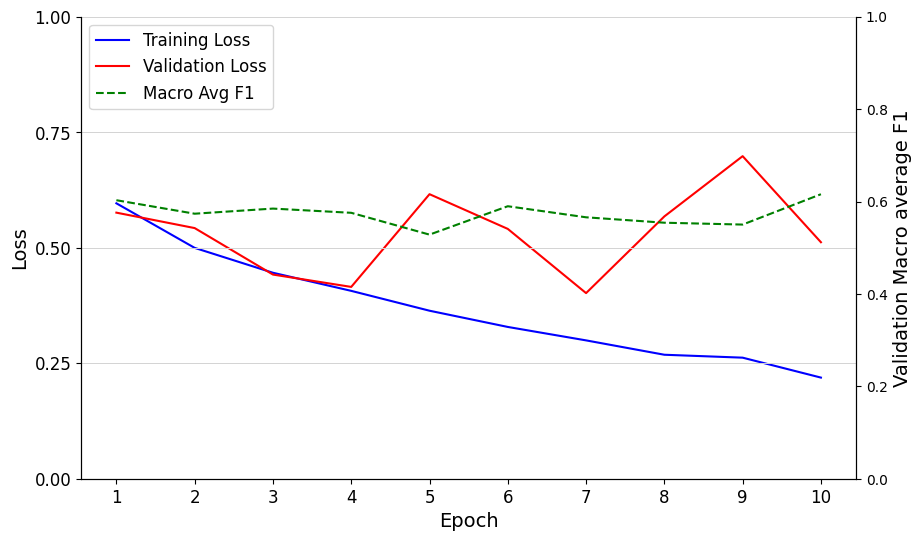

In [ ]:
N_EPOCHS = 20

train_losses = []
valid_losses = []
macro_f1_scores = []
total_steps = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc, steps_in_epoch = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, epoch_macro_f1 = evaluate(model, valid_loader, criterion) # new part: epoch_macro_f1
    total_steps += steps_in_epoch

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    macro_f1_scores.append(epoch_macro_f1)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Macro Avg F1 score: {epoch_macro_f1:.2f}')

torch.save(model.state_dict(), SAVE_WEIGHTS_WITHOUT_HEAD_PATH)
print('Model weights saved')
print('Total steps: ', total_steps)

state_dict = model.state_dict()

del state_dict['output_layer.weight']
del state_dict['output_layer.bias']
# save the modified state dictionary without the output_layer's weights and bias
torch.save(state_dict, SAVE_WEIGHTS_WITHOUT_HEAD_PATH)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), train_losses, color='blue', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), valid_losses, color='red', label='Validation Loss')

plt.xticks(range(1, N_EPOCHS+1))
max_loss = max(max(train_losses), max(valid_losses))
max_val = round(max_loss + 0.5, 1)
LARGE_TICK_SPACING = True
if not LARGE_TICK_SPACING:
  yticks = [i for i in np.arange(0, max_val, 0.5)]
else:
  yticks = [i for i in np.arange(0, max_val, 0.25)]
plt.yticks(yticks)

for y in yticks:
    plt.axhline(y, color='lightgrey', linewidth=0.7)

ax = plt.gca()
ax.spines['right'].set_color('black')
ax.spines['top'].set_visible(False)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax2 = ax.twinx()
ax2.plot(range(1, N_EPOCHS+1), macro_f1_scores, color='green', label='Macro Avg F1', linestyle='--')
ax2.set_ylabel('Validation Macro average F1', fontsize=14)
ax2.set_ylim(0, 1)  # since F1 score range is [0, 1]
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['top'].set_visible(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

plt.savefig(SAVE_PLOT_IMG_PATH)
print('Plot of loss saved')
plt.show()